In [1]:
import numpy as np
import torch
from torch import FloatTensor,Tensor,LongTensor
from deterministicpolicy import DeterministicActorCritic # REINFORCE, ActorCritic,
import gym
import random
import matplotlib.pyplot as plt
import time

In [2]:
a = [4,500,500]

b = np.full(10,500)
np.concatenate((a,b))

array([  4, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500])

In [ ]:
def Cartpole(total_episodes, learning_rate, future_reward_discount_factor, hidden_shape):
    """
    Tries to solve Cartpole-v1 usinf the REINFORCE algorithm. Right now it only applies a Monte-Carlo REINFORCE

    Args:
        total_episodes: How many times the environment resets
        learning_rate: For optimizer
        future_reward_discount_factor: future rewards are dicounted
        hidden_shape: List of integers. [16,16] would give two hidden layers (linear with PReLU activation) with both 16 nodes in the policy model

    Returns:
        scores: Score per episode in a list
    """


    scores = []
    env = gym.make("CartPole-v1")
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, learning_rate, future_reward_discount_factor, hidden_shape)

    for i in range(total_episodes):
        #reset the environment
        state = env.reset()
        rewards = []
        log_probs = []

        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            #env.render()
            #Action selection is done by the policy
            action, log_prob = agent.model.pick(state)

            #Get example
            state, reward, done, _ = env.step(action)

            rewards.append(reward)
            log_probs.append(log_prob)

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break

        rewards = torch.tensor(rewards)
        log_probs = torch.cat(log_probs)
        agent.update(rewards,log_probs)

        scores.append(t+1)

        #Cartpole v1 is considered solved when
        # the average over the last 100 consecutive episodes is at least 475
        if np.mean(scores[-100:]) >= 475:
            mask = np.full(total_episodes - (i + 1),500)
            scores = np.concatenate((scores,mask))
            print("Solved!")
            break

    if np.mean(scores[-100:]) < 475:
        print("Not Solved...")
    return scores


In [ ]:
#Parameters
total_episodes = 1000
learning_rate = 1e-2
future_reward_discount_factor = 1
hidden_shape = [32]

score = Cartpole(total_episodes, learning_rate, future_reward_discount_factor, hidden_shape)

In [ ]:
#Plot score per episode
plt.plot(np.arange(1,total_episodes+1), score)
plt.xlabel("Episode")
plt.ylabel("Score")

In [ ]:
def AC(total_episodes, estimation_depth, learning_rate, gradient_method, hidden_shape_actor, hidden_shape_critic):
    """
    Tries to solve Cartpole-v1 usinf the REINFORCE algorithm. Right now it only applies a Monte-Carlo REINFORCE

    Args:
        total_episodes: How many times the environment resets
        learning_rate: For optimizer
        future_reward_discount_factor: future rewards are dicounted
        hidden_shape: List of integers. [16,16] would give two hidden layers (linear with PReLU activation) with both 16 nodes in the policy model

    Returns:
        scores: Score per episode in a list
    """


    scores = []
    env = gym.make("CartPole-v1")
    agent = ActorCritic(env.observation_space.shape[0], env.action_space.n, estimation_depth, gradient_method, learning_rate, hidden_shape_actor, hidden_shape_critic)
    counter = 0

    for i in range(total_episodes):
        #reset the environment
        state = env.reset()
        rewards = []
        log_probs = []
        states = []

        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            #env.render()
            states.append(state)

            #Action selection is done by the policy
            action, log_prob = agent.actor.pick(state)

            #Get example
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break

        states = torch.Tensor(np.array(states))
        rewards = np.array(rewards)
        log_probs = torch.cat(log_probs)
        agent.update(rewards,log_probs, states)

        scores.append(t+1)
        #Cartpole v1 is considered solved when
        # the average over the last 100 consecutive episodes is at least 475
        if np.mean(scores[-100:]) >= 475:
            mask = np.full(total_episodes - (i + 1),500)
            scores = np.concatenate((scores,mask))
            print("Solved!")
            break
    if np.mean(scores[-100:]) < 475:
        print("Not Solved...")
    return scores

In [ ]:
#Parameters
total_episodes = 1000
learning_rate = 1e-2
estimation_depth = 500
gradient_method = 'both'
hidden_shape_actor = [16]
hidden_shape_critic = [16]

score = AC(total_episodes, estimation_depth, learning_rate, gradient_method, hidden_shape_actor, hidden_shape_critic)

In [ ]:
#Plot score per episode
plt.plot(np.arange(1,total_episodes+1), score)
plt.xlabel("Episode")
plt.ylabel("Score")

In [10]:
from traineval.training.custom_DRL.drlmain.spinning_up_evaluation import evaluate
import joblib
import timeit
from traineval.utils.register_environment import register_environment
from traineval.utils.convert_arguments import get_environment_arguments
from traineval.training.spinningup.environments import epoch_citylearn
import os.path as osp
import pickle


def AC(total_episodes, estimation_depth, learning_rate, gradient_method, hidden_shape_actor, hidden_shape_critic, epsilon):
    """
    Tries to solve Cartpole-v1 usinf the REINFORCE algorithm. Right now it only applies a Monte-Carlo REINFORCE

    Args:
        total_episodes: How many times the environment resets
        learning_rate: For optimizer
        future_reward_discount_factor: future rewards are dicounted
        hidden_shape: List of integers. [16,16] would give two hidden layers (linear with PReLU activation) with both 16 nodes in the policy model

    Returns:
        scores: Score per episode in a list
    """

    # district_args = ["hour",
    #                  "month",
    #                  "carbon_intensity",
    #                  "electricity_pricing"]
    #
    # building_args = ["non_shiftable_load",
    #                  "solar_generation",
    #                  "electrical_storage_soc",
    #                  "net_electricity_consumption"]

    district_args = ["hour", "carbon_intensity", "electricity_pricing"]
    building_args = ["electrical_storage_soc"]

    environment_arguments = get_environment_arguments(district_args, building_args)
    register_environment(environment_arguments)

    scores = []

    env = gym.make("Epoch-Citylearn-v1")

    action_space = 1
    gamma = 0.92
    agent = DeterministicActorCritic(env.observation_space.shape[0], action_space, estimation_depth, gamma, gradient_method, learning_rate, hidden_shape_actor, hidden_shape_critic, epsilon)


    for i in range(total_episodes):
        #reset the environment
        state = env.reset()

        t = 0

        # while t < 8760 - 1:

        observations = []
        actions = []
        rewards = []
        next_observations = []
        dones = []
        for x in range(24):

            observations.append(state)

            #Action selection is done by the policy
            action = agent.pick(state)
            actions.append(action)
            # print(t, x)

            #Get example
            state, reward, done, _ = env.step(action.tolist()[0] * 5)
            reward = (((reward - (-3)) * (1 - (-0))) / (-0.2 - (-3))) + (-0)

            rewards.append(reward)
            next_observations.append(state)
            dones.append(done)

            t += 1

            if done or x == 24-1:
                print(f"Day {i} finished, mean score: {np.mean(rewards)}")
                scores.append(np.mean(rewards))
                break

        observations = torch.FloatTensor(np.array(observations))
        actions = torch.cat(actions)
        next_observations = torch.FloatTensor(np.array(next_observations))
        dones = torch.Tensor(np.array(dones))
        rewards = torch.FloatTensor(np.array(rewards))

        agent.update(data={"obs":observations,"act":actions,"rew":rewards,"obs2":next_observations,"done":dones})

        torch.save(agent.retrieve_actor(), "wowamodela.pt")

        # Following doesn't work, probably keeps trying the same model
        # if i % 5000 == 0:
        #     evaluate(environment_arguments, "ppo", 0, 0, True)

        # year_mean = np.average(rewards)
        # scores.append(year_mean)
        # print(f"Year {i} done with average reward {year_mean}")

    return scores

In [16]:
#Parameters
total_episodes = 100*365
learning_rate = 0.02
estimation_depth = 500  ## DEPR
gradient_method = 'both' ## DEPR
hidden_shape_actor = [32]
hidden_shape_critic = [32]
epsilon = 0.2

scores_to_plot = AC(total_episodes, estimation_depth, learning_rate, gradient_method, hidden_shape_actor, hidden_shape_critic, epsilon)

Day 0 finished, mean score: 0.07209199059763127
Day 1 finished, mean score: 0.9226590574484551
Day 2 finished, mean score: 0.47018831638542946
Day 3 finished, mean score: 0.34498509251796855
Day 4 finished, mean score: 0.25688162647308727
Day 5 finished, mean score: 0.23077854805542355
Day 6 finished, mean score: 0.0959110407377587
Day 7 finished, mean score: 0.08804052442261046
Day 8 finished, mean score: 0.057467849164818056
Day 9 finished, mean score: 0.1831350101418218
Day 10 finished, mean score: 0.05370971995574936
Day 11 finished, mean score: 0.1849044686514935
Day 12 finished, mean score: 0.09898105672045625
Day 13 finished, mean score: 0.142743903668004
Day 14 finished, mean score: 0.12901771670446088
Day 15 finished, mean score: 0.08960039317589129
Day 16 finished, mean score: 0.22414178674092375
Day 17 finished, mean score: 0.1445418401177669
Day 18 finished, mean score: 0.051734908805602164
Day 19 finished, mean score: 0.0938022364221822
Day 20 finished, mean score: 0.22082

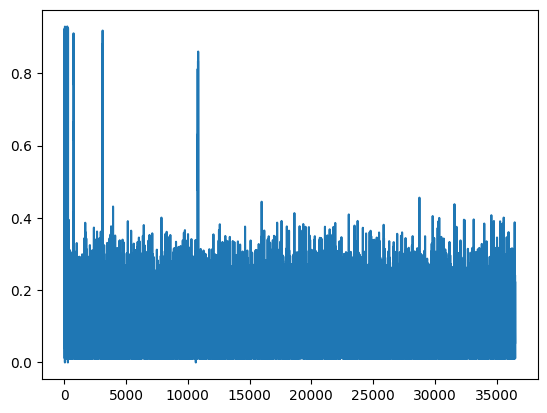

In [17]:
plt.plot(scores_to_plot)

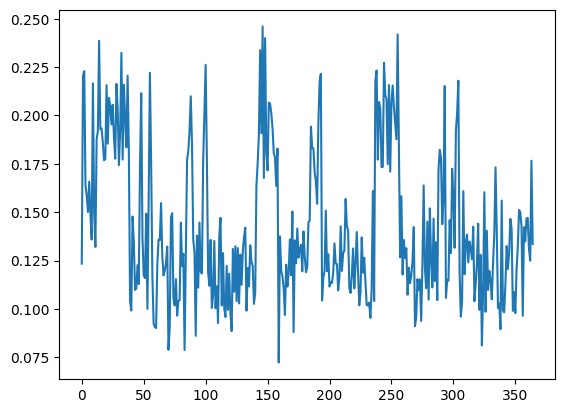

In [18]:
years = np.mean(np.array([scores_to_plot[i*365:i*365+365] for i in range(10)]), axis = 0)
plt.plot(years)